In [12]:
from langchain.schema import Document
from unsloth import FastLanguageModel
import torch
from typing import TypedDict
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from rag.utils import format_docs
from langchain_upstage import UpstageGroundednessCheck

In [13]:
# Step 1: GraphState 정의
class GraphState(TypedDict):
    question: str  # 질문
    context: str   # 문서의 검색 결과
    answer: str    # 답변
    relevance: str # 답변의 문서에 대한 관련성
    retries: int   # 재귀 시도 횟수


In [14]:
# Step 2: UpstageGroundednessCheck 초기화
upstage_ground_checker = UpstageGroundednessCheck()

# 모델 및 토크나이저 선언
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Qwen2-7B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2024.10.3: Fast Qwen2 patching. Transformers = 4.45.2.
   \\   /|    GPU: NVIDIA A100 80GB PCIe MIG 3g.40gb. Max memory: 39.5 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [15]:
# LoRA Adapter 선언
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
    use_rslora=False,
    loftq_config=None
)

In [16]:
prompt_format = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

In [17]:
def formatting_prompts_func(examples):
    instructions = examples["text"]
    outputs = examples["text"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        text = prompt_format.format(instruction, output) + EOS_TOKEN
        texts.append(text)
    return {"formatted_text": texts, }

In [18]:
# 데이터셋 로드 및 포맷팅
dataset = load_dataset("Linq-AI-Research/FinanceRAG", 'FinQABench', split="corpus")
dataset = dataset.map(formatting_prompts_func, batched=True)

In [19]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="formatted_text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs",
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [20]:
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 3584)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=3584, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3584, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
       

In [24]:
import sys

# 문서 검색 함수
def retrieve_document(state: GraphState) -> GraphState:
    # 실제로는 검색기를 사용하여 문서를 검색해야 합니다.
    # 여기서는 예시로 간단한 문서를 사용합니다.
    retrieved_docs = [
        Document(
            page_content="화폐의 시간가치는 미래의 금액을 현재의 가치로 환산하는 개념입니다.",
            metadata={"source": "FinanceDocument", "page": 1}
        )
    ]
    context = format_docs(retrieved_docs)
    state["context"] = context
    return state

# 모델을 사용하여 답변 생성 함수
def llm_answer(state: GraphState) -> GraphState:
    inputs = tokenizer(
        [
            prompt_format.format(
                state["question"],
                ""
            )
        ], return_tensors="pt"
    ).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=256, use_cache=True)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    state["answer"] = decoded_output
    return state

# 그라운드 체크 함수
def relevance_check(state: GraphState) -> GraphState:
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    state["relevance"] = response
    return state

# 관련성 판단 함수
def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "grounded":
        return "END"
    else:
        return "retrieve"

# Step 4: 그래프 정의 및 컴파일

workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)

# 엣지 추가
workflow.add_edge("retrieve", "llm_answer")
workflow.add_edge("llm_answer", "relevance_check")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "END": END,
        "retrieve": "retrieve",
    },
)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 워크플로우 컴파일
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Step 5: 워크플로우 실행

config = RunnableConfig(recursion_limit=13, configurable={"thread_id": "SELF-RAG"})

# 초기 상태 설정
inputs = GraphState(question="엔비디아 주가는 앞으로 오를 것 같아? yes나 no로 대답해줘.")

try:
    # 워크플로우 실행
    output = app.invoke(inputs, config=config)
    
    # 결과 출력
    print("Question: \t", output["question"])
    print("Answer: \t", output["answer"])
    print("Relevance: \t", output["relevance"])

except RecursionError:
    # 재귀 한도를 초과한 경우 처리
    print("정보를 찾을 수 없습니다. 재귀 횟수가 초과되었습니다.")


정보를 찾을 수 없습니다. 재귀 횟수가 초과되었습니다.


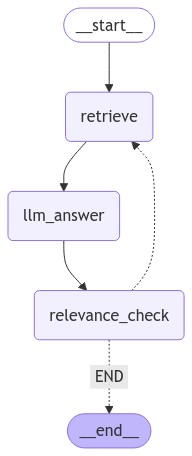

In [25]:
from IPython.display import Image, display

# 워크플로우 시각화 호출
try:
    # Mermaid 형식의 그래프를 PNG로 변환하여 표시
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )
except Exception as e:
    # 오류가 발생할 경우 예외 처리
    print(f"Error displaying workflow graph: {e}")
